# **Laboratorio 1 - SIS420**

**MLP con Framework HAIKU**

Arancibia Aguilar Daniel Andree

Ingeniería en Ciencias de la Computación

En este laboratorio usaremos un framework diferente para crear un MLP 

Usaremos un dataset de 500 imagenes 100 por cada planta

Coca

Eucalipto

Guanabana

Lengua de Suegra

Manzanilla

**Importamos las librerias**

In [14]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import matplotlib.pyplot as plt


In [ ]:
#Definimos los parametros del MLP ademas de reescalar las imagenes a 256x256
image_size = (256, 256)
num_classes = 5
batch_size = 64
num_epochs = 20
learning_rate = 0.001

Cargamos las imagenes para crear el dataset

In [ ]:
# Ruta del dataset
image_dir = 'E:/LAB1SIS421/DatasetPlantas1'

#Cargar imágenes y etiquetas
def load_data(image_dir, image_size):
    image_files = []
    labels = []
    class_names = sorted(os.listdir(image_dir))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(image_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img = Image.open(os.path.join(class_dir, img_file)).resize(image_size)
                    img = np.array(img) / 255.0  # Normalizar
                    image_files.append(img)
                    labels.append(label)
    return np.array(image_files), np.array(labels)

#Dividir en entrenamiento y prueba
images, labels = load_data(image_dir, image_size)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

Se define una red neuronal con tres capas (512, 256 y 5 clases) utilizando haiku.Sequential.

In [ ]:
# Definir el modelo MLP
def mlp_fn(x):
    mlp = hk.Sequential([
        hk.Flatten(),
        hk.Linear(512), jax.nn.relu,
        hk.Linear(256), jax.nn.relu,
        hk.Linear(num_classes),
    ])
    return mlp(x)

In [ ]:
# Funciones Haiku
def forward_fn(x):
    mlp = mlp_fn(x)
    return mlp
#hk.transform convierte la función forward_fn en un objeto que puede ser usado para inicializar el modelo y aplicarle parámetros.
model = hk.transform(forward_fn)

#Definir la función de pérdida
def loss_fn(params, rng, x, y):
    logits = model.apply(params, rng, x)
    labels_onehot = jax.nn.one_hot(y, num_classes)
    loss = optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()
    return loss

#Definir la función de precisión
def accuracy_fn(params, rng, x, y):
    logits = model.apply(params, rng, x)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == y)
    return accuracy

#Inicializar el modelo y el optimizador 
#rng es una clave de generación de números aleatorios de JAX. init_rng se usa para inicializar el modelo.
rng = jax.random.PRNGKey(42)
rng, init_rng = jax.random.split(rng)
params = model.init(init_rng, jnp.ones((1, *image_size, 3), jnp.float32))
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

#Función de entrenamiento
@jax.jit
def train_step(params, opt_state, rng, x, y):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

#Función de evaluación
@jax.jit
def evaluate(params, rng, x, y):
    return accuracy_fn(params, rng, x, y)


@jax.jit es un decorador en JAX que significa "Just-In-Time" compilation. Su propósito principal es optimizar y acelerar la ejecución de funciones al compilar el código Python en un código de máquina más eficiente

Epoch 1, Loss: 31.3218, Train Accuracy: 0.3650
Epoch 2, Loss: 26.0612, Train Accuracy: 0.3375
Epoch 3, Loss: 7.3925, Train Accuracy: 0.2825
Epoch 4, Loss: 2.4623, Train Accuracy: 0.7350
Epoch 5, Loss: 1.3550, Train Accuracy: 0.5425
Epoch 6, Loss: 2.2365, Train Accuracy: 0.7450
Epoch 7, Loss: 1.9366, Train Accuracy: 0.8250
Epoch 8, Loss: 0.2373, Train Accuracy: 0.8125
Epoch 9, Loss: 0.7222, Train Accuracy: 0.9075
Epoch 10, Loss: 0.6172, Train Accuracy: 0.7675
Epoch 11, Loss: 0.2612, Train Accuracy: 0.9000
Epoch 12, Loss: 0.1750, Train Accuracy: 0.9525
Epoch 13, Loss: 0.1047, Train Accuracy: 0.8650
Epoch 14, Loss: 0.2949, Train Accuracy: 0.9250
Epoch 15, Loss: 0.1153, Train Accuracy: 0.8375
Epoch 16, Loss: 0.5550, Train Accuracy: 0.8200
Epoch 17, Loss: 0.5470, Train Accuracy: 0.8900
Epoch 18, Loss: 0.0921, Train Accuracy: 0.8950
Epoch 19, Loss: 0.0034, Train Accuracy: 0.9675
Epoch 20, Loss: 0.1758, Train Accuracy: 0.9950
Entrenamiento completo
Test Accuracy: 86.00 %


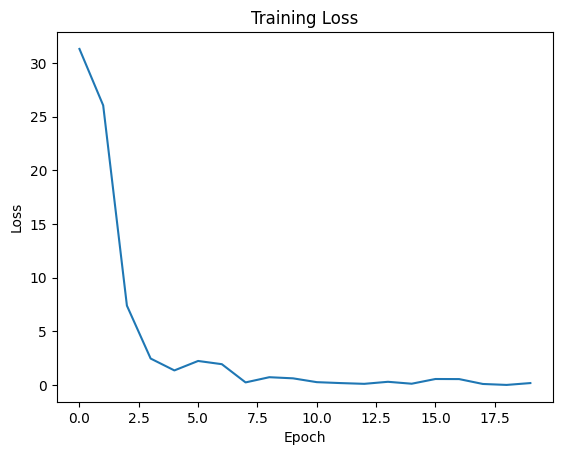

In [9]:
# Entrenamiento del modelo
train_losses = []
for epoch in range(num_epochs):
    indices = np.random.permutation(len(train_images))
    train_images = train_images[indices]
    train_labels = train_labels[indices]
    
    for i in range(0, len(train_images), batch_size):
        x_batch = jnp.array(train_images[i:i + batch_size])
        y_batch = jnp.array(train_labels[i:i + batch_size])
        rng, step_rng = jax.random.split(rng)
        params, opt_state, loss = train_step(params, opt_state, step_rng, x_batch, y_batch)
    
    train_loss = loss.item()
    train_losses.append(train_loss)
    rng, eval_rng = jax.random.split(rng)
    train_accuracy = evaluate(params, eval_rng, jnp.array(train_images), jnp.array(train_labels)).item()
    print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print('Entrenamiento completo')

# Evaluación del modelo en el conjunto de prueba
rng, test_rng = jax.random.split(rng)
test_accuracy = evaluate(params, test_rng, jnp.array(test_images), jnp.array(test_labels)).item()
print(f'Test Accuracy: {test_accuracy * 100:.2f} %')

# Graficar la pérdida de entrenamiento
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
